In [1]:
import os, math, sys
from sys import stdout

import numpy as np
import matplotlib.pyplot as plt
import openmm.app  as omm_app
import openmm as omm
import simtk.unit as unit
from tqdm import tqdm

import MDAnalysis as mda
from MDAnalysis.analysis import align, rms

/Users/shashanksule/miniforge3/envs/mdenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/shashanksule/miniforge3/envs/mdenv/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


### Citing: Most of the openmm data needed for butane and format of this notebook comes from [here](https://fastmbar.readthedocs.io/en/latest/butane_PMF.html).

In [2]:
# Indicates whether to run a simulation or not
SIMULATE = True

## 1. Construct an OpenMM system of butane
We set up the MD molecular system in the format/object required by OpenMM, a class called
[System](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.System.html).

In [11]:
psf = omm_app.CharmmPsfFile('../data/butane.psf')
pdb = omm_app.PDBFile('../data/butane.pdb')
topology = psf.topology

In [12]:
params = omm_app.CharmmParameterSet('../data/top_all35_ethers.rtf',
                                    '../data/par_all35_ethers.prm')

In [13]:
system = psf.createSystem(params, nonbondedMethod=omm_app.NoCutoff)

In [14]:
with open("../output/system.xml", 'w') as file_handle:
    file_handle.write(omm.XmlSerializer.serialize(system))

In [15]:
## read the OpenMM system of butane
with open("../output/system.xml", 'r') as file_handle:
    xml = file_handle.read()
system = omm.XmlSerializer.deserialize(xml)

## read psf and pdb file of butane
psf = omm_app.CharmmPsfFile("../data/butane.psf")
pdb = omm_app.PDBFile('../data/butane.pdb')
topology = psf.topology

# 1.a Set up Metadynamics

In [16]:
# Define Collective Variable
cv_cos = omm.CustomTorsionForce("cos(theta)")
cv_sin = omm.CustomTorsionForce("sin(theta)")
cv_cos.addTorsion(3, 6, 9, 13)
cv_sin.addTorsion(3, 6, 9, 13)
# Set metadynamics parameters
biasWidth=0.1
# phi = omm_app.metadynamics.BiasVariable(force=cv, minValue=-np.pi, maxValue=np.pi, biasWidth=biasWidth, periodic=True, gridWidth=1000)
psi = omm_app.metadynamics.BiasVariable(force=cv_cos, minValue=-1.2, maxValue=1.2, biasWidth=biasWidth, periodic=False, gridWidth=1000)
phi = omm_app.metadynamics.BiasVariable(force=cv_sin, minValue=-1.2, maxValue=1.2, biasWidth=biasWidth, periodic=False, gridWidth=1000)


# 2. Set up and run the simulation

In [11]:
# platform
platform = omm.Platform.getPlatformByName('CUDA')

T = 300 * unit.kelvin  ## temperature
kbT = unit.BOLTZMANN_CONSTANT_kB * T * unit.AVOGADRO_CONSTANT_NA 
kbT = kbT.value_in_unit(unit.kilojoule_per_mole)

kbT_roomtemp = unit.BOLTZMANN_CONSTANT_kB*unit.AVOGADRO_CONSTANT_NA*300.0*unit.kelvin
kbT_roomtemp = kbT_roomtemp.value_in_unit(unit.kilojoule_per_mole)

# Set up metadynamics
biasFactor = 10
height = 0.1
frequency = 1E2
meta = omm_app.Metadynamics(system, variables=[phi, psi], temperature=T, biasFactor=biasFactor, height=height, frequency=frequency, saveFrequency=frequency, biasDir="../output/dihedral_TPT/")

## integrator
fricCoef = 10/unit.picoseconds ## friction coefficient 
stepsize = 2 * unit.femtoseconds ## integration step size
integrator = omm.LangevinMiddleIntegrator(T, fricCoef, stepsize)
simulation = omm_app.Simulation(topology, system, integrator)

OpenMMException: There is no registered Platform called "CUDA"

We minimize the energy before running the simulations, and then add "reporters" to track various info on the simulation: the [DCD reporter](http://docs.openmm.org/7.2.0/api-python/generated/simtk.openmm.app.dcdreporter.DCDReporter.html#) records positions of atoms at each 100 steps (in a compressed format), and the [StateDataReporter](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.app.statedatareporter.StateDataReporter.html#) records the potential energy at each 100 steps.

Then, we simulate.

In [19]:
my_state = f"state_metad_sep29.txt"
my_dcd = f"traj_metad_sep29.dcd"
my_free_energy = f"free_energy_sep29.npz"
SIMULATE = False
if SIMULATE:
    simulation.context.setPositions(pdb.positions)
    if psf.boxVectors is not None:
        print("we got box vectors!")
        simulation.context.setPeriodicBoxVectors(*psf.boxVectors)
    simulation.minimizeEnergy()
    
    simulation.reporters.append(omm_app.DCDReporter(my_dcd, int(1E1)))
    # simulation.reporters.append(omm_app.StateDataReporter(my_state, 1E1, step=True, potentialEnergy=True))
    simulation.reporters.append(omm_app.StateDataReporter(stdout, 1E5, step=True, potentialEnergy=True))

In [23]:
meta.step(simulation, 1E6)
# np.savez(my_free_energy, free_energy=meta.getFreeEnergy())

300000,104.68647112308233
400000,81.44095361392525
500000,79.44519812473337
600000,91.7173938215016
700000,73.25652982215004
800000,67.46829195852655
900000,97.45841381762224
1000000,91.62936932750958
1100000,88.2900993966507
1200000,87.69560294711438


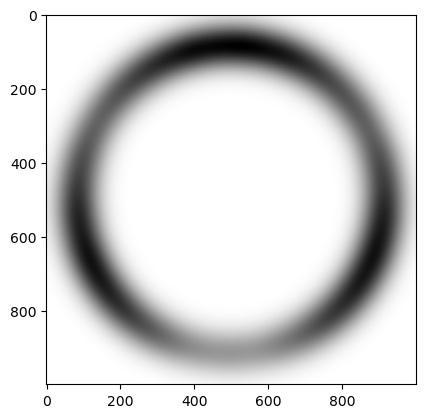

In [30]:
plt.imshow(meta.getFreeEnergy(), cmap='grey')